# GA_ANN House Price - OctibaNima Group

## Data Cleaning Part (Code and Explanation)
- This file DataCleaning.ipynb contains code, background reasoning, and complete explanation for the Data Cleaning Part of this project.
- The code is the same in the Data.py, which contains code only, without visualization and background reasoning. Data.py is made as a function that return the cleaned dataframe, to be called from the main function. When calling the function data_cleaning (in Data.py) from the main function, it will run the cleaning exactly the same as the sequence of this file, however it will not give the background reasoning (visualization), only for purpose of returning cleaned dataframe for further process.

In [63]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns


### 1. Read Data and drop columns which are not useful
#### 1.1 PID and Order 
- PID and Order have unique values and functioned more like index of records rather than contributing as useable features. Therefore PID and Order are removed.

In [64]:
main = pd.read_csv ('AmesHousing.csv',encoding = 'latin-1') 

#Deleting the space in the column name
main.columns = main.columns.str.replace(' ', '')

#Remove duplicated rows if any
main.drop_duplicates(inplace = True)

#We see that PID and Order might not be useful for getting prediction as they only a unique ID and sequence number
#that does not have correlation to SalePrice or to other columns
print('Duplicates for PID, Order : ',main.PID.duplicated().sum(), main.Order.duplicated().sum())

#There is no duplicates of PID and order which shows it is only a sequence of number, so we drop PID and Order
main = main.drop(['PID','Order'], 1)



Duplicates for PID, Order :  0 0


### 2. Handling Missing Values

#### 2.1 Filling in the missing value and convert to numerical category based on the rank of the mean of SalePrice
- By looking at the data description file, we see that the values for some of the columns are Nan due to “no facilities” available. 
- Therefore, we change the Nan values to string “NA”, so we can categorize them properly. 
- After filling missing values with string “NA”, we converted the values to numerical category and ranked based on mean values of SalePrice for each of category. For example: starting from 0 for the category which have lowest mean SalePrice.

In [65]:

# List of the column name which have NAN value, but it is actually and NA (no facility available)
no_facility = ['Alley','FireplaceQu','GarageFinish','GarageType','GarageQual','GarageCond','PoolQC','Fence','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']

for name in no_facility:
    main[name]=main[name].fillna('NA')
    # To score them, we groupby by the column name and categorize them by the mean of sale price for each unique value
    # sort the unique value by the mean of sale price from low to high and keep them in the list
    grouped = main.groupby(name)['SalePrice'].mean().reset_index().sort_values(by='SalePrice').reset_index(drop=True)
    replace_list = list(grouped[name])
    # for each value in the columns, replace with the index from the list(which shows the rank/score), for each value.
    main[name]=main[name].apply(lambda x: replace_list.index(x))


#Fill in MiscFeature with NA, since NAN is Not available
main['MiscFeature']=main['MiscFeature'].fillna('NA')


#### 2.2	Garage Cars and Garage Area

In [66]:

##Fill in GarageCars and Garage Area with 0, as the status of GarageType is NA
#The reasone is similar as above, the Nan values means no facility available, therefore as this is numerical, fill in Nans for both columns with 0.
main['GarageCars']=main['GarageCars'].fillna(0)
main['GarageArea']=main['GarageArea'].fillna(0)

##The rest of Nan Values for Lot Frontage, GarageYrBuilt will be fill in  by the median value
print(main.isnull().sum())


MSSubClass         0
MSZoning           0
LotFrontage      490
LotArea            0
Street             0
Alley              0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemod/Add      0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType        23
MasVnrArea        23
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
                ... 
BedroomAbvGr       0
KitchenAbvGr       0
KitchenQual        0
TotRmsAbvGrd       0
Functional         0
Fireplaces         0
FireplaceQu        0
GarageType         0
GarageYrBlt      159
GarageFinish       0
GarageCars         0
GarageArea         0
GarageQual         0
GarageCond         0
PavedDrive         0
WoodDeckSF         0
OpenPorchSF  

### 3. Cleanse inconsistency of paired features
#### 3.1	MasVnrType and MasVnrArea
- Fill in the missing value Nan in MasVnrType with string ‘None’, as there is a category called ‘None’. Fill in the missing value (Nan) in MasVnrArea with 0 since the category in MasVnrType is ‘None’
- Both records comes as a pair and therefore there has to be consistency between those two features, such as 'None' values in MasVnrType should have zero values in MasVnrArea. However we found several records that are not 0.
- For those records, we did the following, where MasVnrType equals to 'None':
    –	Replace value '1' in MasVnrArea to '0' assuming that it's a typo
    –	Replace 'None' in MasVnrType to most common values (mode) which have MasVnrArea not equal to zero


In [67]:
#MasVnrType and MasVnrArea
#fill in with None for the NA, as one of the category of Mas VnrType is None, and for category NOne, the MasVnrArea is 0
main['MasVnrType']=main['MasVnrType'].fillna('None')
main['MasVnrArea']=main['MasVnrArea'].fillna(0)

#There is inconsistency with the MasVnrType, None, some of it have value > 0
temp_df=main[main.MasVnrType=='None']
MasVnrNone = temp_df.loc[:,['MasVnrType','MasVnrArea']].pivot_table(index=['MasVnrType','MasVnrArea'],aggfunc='count')

print('MasVnrNone have MasVnrArea values as follows : ',MasVnrNone)

#as wee see that None should have value 0, for the one have value 1 is possbily typo, so we replace with 0
main.loc[(main.loc[:,'MasVnrArea'] == 1) & (main.loc[:,'MasVnrType'] == 'None'),'MasVnrArea'] = 0

#For MasVnrType None, with MasVnrArea > 0, we change the MasVnrType to the mode() of the MasVnrType (as it should not be NONE)
main.loc[(main.loc[:,'MasVnrArea'] != 0) & (main.loc[:,'MasVnrType'] == 'None'),'MasVnrType'] =main.loc[main.loc[:,'MasVnrType'] != 'None','MasVnrType'].mode()[0]

main.isnull().sum()

MasVnrNone have MasVnrArea values as follows :  Empty DataFrame
Columns: []
Index: [(None, 0.0), (None, 1.0), (None, 285.0), (None, 288.0), (None, 312.0), (None, 344.0)]


MSSubClass         0
MSZoning           0
LotFrontage      490
LotArea            0
Street             0
Alley              0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemod/Add      0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
                ... 
BedroomAbvGr       0
KitchenAbvGr       0
KitchenQual        0
TotRmsAbvGrd       0
Functional         0
Fireplaces         0
FireplaceQu        0
GarageType         0
GarageYrBlt      159
GarageFinish       0
GarageCars         0
GarageArea         0
GarageQual         0
GarageCond         0
PavedDrive         0
WoodDeckSF         0
OpenPorchSF  

### 4. Cleanse Categorical features
#### 4.2	Convert to numerical features, with ranking based on common understanding
- Convert to numerical features, with ranking based on common understanding. Conversion of features done by defining ranks manually and replace the categorical values with predefined ranks.

In [68]:
#convert categorical to numerical manually for columns with ranking 
cleanup_dicts= {'ExterQual':    {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa':1, 'Po':0},
                'ExterCond':    {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa':1, 'Po':0},
                'Functional' :  {'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod':4, 'Maj1':3, 'Maj2':2,'Sev': 1, 'Sal': 0},
                'SaleCondition':{'Normal': 5, 'Abnorml':4, 'AdjLand':3,'Alloca':2,'Family':1,'Partial': 0},
                'HeatingQC':    {'Normal': 5, 'Abnorml':4, 'AdjLand':3,'Alloca':2,'Family':1,'Partial': 0},
                'LotShape' :    {'Reg':3,'IR3':2,'IR2':1,'IR1':0},
                'Utilities':    {'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0},
                'HeatingQC':   {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa':1, 'Po':0},
                'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa':1, 'Po':0}           
}
                 
main.replace(cleanup_dicts, inplace = True)



#### 4.3	Convert to numerical features, without ranking
- All other features which are not unit numbers (feet, years, values) are converted to numerical values based on sequence of appearance, due to the features cannot be categorized based on rank. For example, first unique value found is set to '0', and so on.


In [69]:
#Filling in columns with which values have no ranking, to be converted to integer 0,1,2,...

column_norank = ['MSZoning','Street','LandSlope','Neighborhood','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
                 'Exterior2nd','Foundation','Heating','CentralAir','Electrical','PavedDrive','SaleType','LandContour','LotConfig',
                 'MasVnrType','Condition1','Condition2','MiscFeature']

#make subset of dataframe with all columns which have values that cannot be ranked
df_norank= main.loc[:,column_norank]

#Change the values for each column to integer 0,1,2,3 .... n, with n is the number of unique value per column
for column in column_norank:
    count_unique = len(df_norank[column].unique())
    temp_unique = df_norank[column].unique()
    for i in range(count_unique):
        df_norank[column][df_norank[column]==temp_unique[i]] = i

#Apply above in the main dataframe        
main.loc[:,column_norank] = df_norank.loc[:,column_norank]


### 5. Fill Nan values with median values
- After all conversion is done, main dataframe is now filled with numeric values. In this case, values  which indicates that there's no features available (for example: no basement, no fence, etc) are already converted to numerical values. At this stage, Nan and null values can be treated as missing data and have to be removed or filled in. we only have columns with missing values which are originally numeric columns (such as LotFrontage and GarageYrBlt)
- We decided to set those Nan and null values with median values of features/columns.


In [70]:
# Fill in the NAN with the median values
main.fillna(main.median(),inplace=True)  

# Checking the summary of dataframe for null values
main.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemod/Add    0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
                ..
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
PoolQC      

### 6. Check Correlation by heatmap
Main Dataframe have all numerical values, so we can do heatmap to analyse the correlation


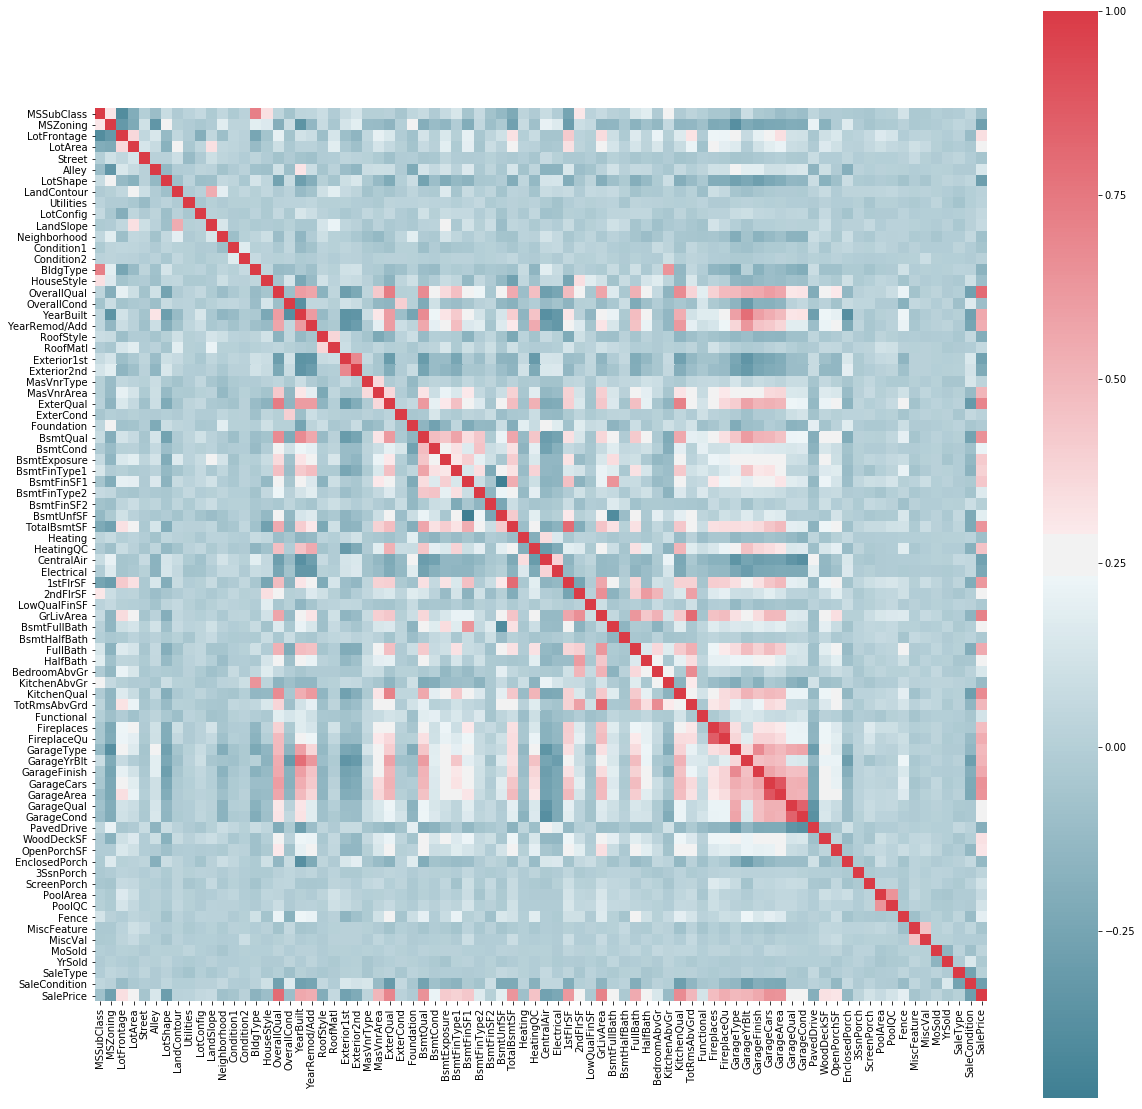

In [71]:
##Make a heatmap to see correlation
f, ax = plt.subplots(figsize=(20, 20))
corr = main.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


### 7. Remove outliers
- By checking almost all columns against the SalePrice  we remove some rows which we considered as outliers as follows:

#### 7.1	Remove outliers in GrLivArea
- From the scattered plot, we can see there are 3 records which have very large grLivArea but with low price. We considered this as noise and remove the records.

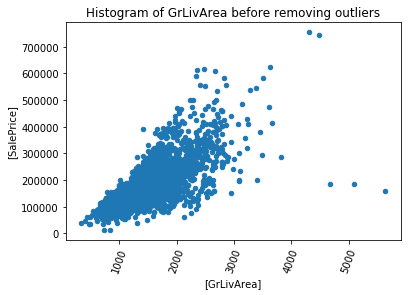

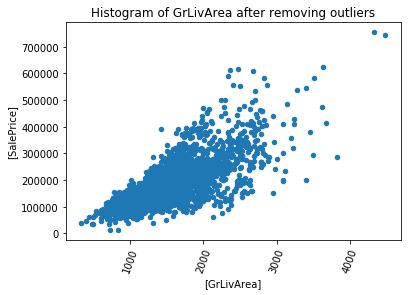

In [72]:
##Plotting GrLivArea and SalePrice and find outlier
main.plot(kind = 'scatter', x = ['GrLivArea'], y = ['SalePrice'], rot=70)
plt.title('Histogram of GrLivArea before removing outliers')
plt.show()

#since we see there is one outlier where grLivArea > 4000 but the price is low
main.drop(main.loc[(main['GrLivArea']>4000) & (main['SalePrice']<300000)].index,inplace=True)

main.plot(kind = 'scatter', x = ['GrLivArea'], y = ['SalePrice'], rot=70)
plt.title('Histogram of GrLivArea after removing outliers')
plt.show()


#### 7.2	Remove outliers in TotRmsAbvGrd
- From the scatter plot, we can see there are 2 records which have high number of TotRmsAbvGrd but with low price. We considered this as noise and remove the records.


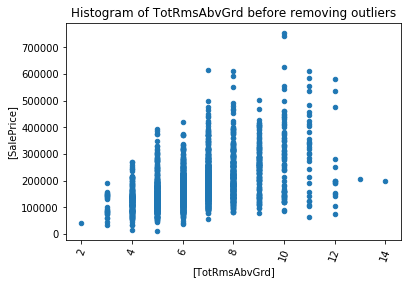

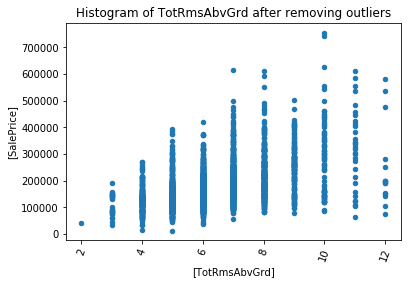

In [73]:
##Plotting TotRmsAbvGrd and SalePrice and find outlier
main.plot(kind = 'scatter', x = ['TotRmsAbvGrd'], y = ['SalePrice'], rot=70)
plt.title('Histogram of TotRmsAbvGrd before removing outliers')
plt.show()

#since we see there is one outlier where TotRmsAbvGrd > 12 but the price are low
main.drop(main.loc[(main['TotRmsAbvGrd']>12) & (main['SalePrice']<300000)].index,inplace=True)

main.plot(kind = 'scatter', x = ['TotRmsAbvGrd'], y = ['SalePrice'], rot=70)
plt.title('Histogram of TotRmsAbvGrd after removing outliers')
plt.show()

#### 7.3 Remove outliers in GarageYrBlt
- There is 1 record scattered which has value greater than year 2200. We assume that this is a typo and update the value directly.


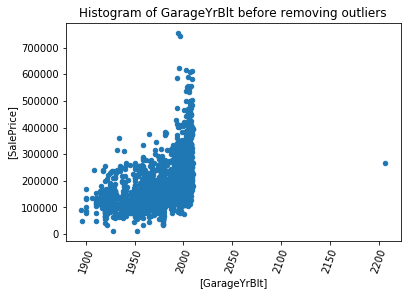

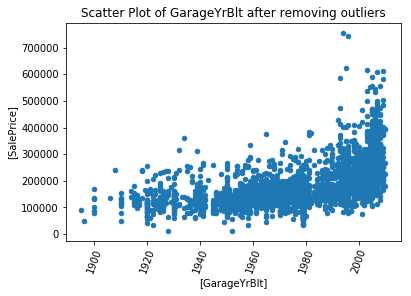

In [74]:
#Remove Outlier in GarageYrBlt
main.plot(kind = 'scatter', x = ['GarageYrBlt'], y = ['SalePrice'], rot=70)
plt.title('Histogram of GarageYrBlt before removing outliers')
plt.show()

#remove row with one data as outlier
main.loc[main.GarageYrBlt == 2207, 'GarageYrBlt'] = 2007

main.plot(kind = 'scatter', x = ['GarageYrBlt'], y = ['SalePrice'], rot=70)
plt.title('Scatter Plot of GarageYrBlt after removing outliers')
plt.show()



#### 7.4 Remove outliers in LotFrontage
- There are 2 records scattered which has value greater than 300, we assume that this is a typo and update the value directly.


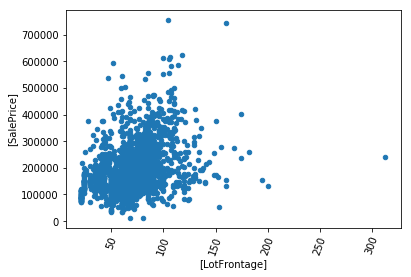

Value which is more than 300 is considered as noise


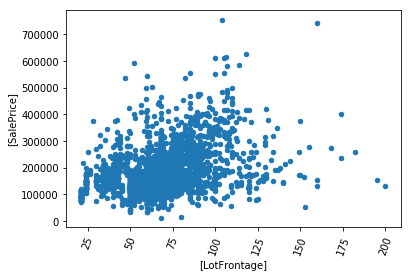

In [75]:
main.plot(kind = 'scatter', x = ['LotFrontage'], y = ['SalePrice'], rot=70)
plt.show()

print('Value which is more than 300 is considered as noise')
main.loc[main.LotFrontage == 313.0, 'LotFrontage'] = 31.0
main.plot(kind = 'scatter', x = ['LotFrontage'], y = ['SalePrice'], rot=70)
plt.show()

#### 7.5 Remove outliers in LotArea
- There are 4 records scattered which have values grater than 100000,  we assume that this is a noise and remove the records.


(2925, 80)


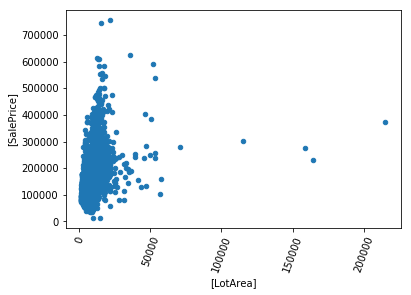

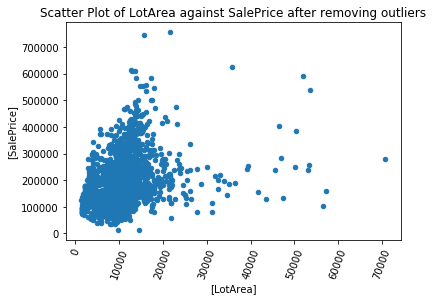

In [76]:
print(main.shape)
main.plot(kind = 'scatter', x = ['LotArea'], y = ['SalePrice'], rot=70)
plt.show()

#main.loc[main.LotArea >= 50000.0,'LotArea'] = round(main.loc[main.LotArea >= 50000.0,'LotArea']/10,0)
main = main[main.LotArea < 100000]

main.plot(kind = 'scatter', x = ['LotArea'], y = ['SalePrice'], rot=70)
plt.title('Scatter Plot of LotArea against SalePrice after removing outliers')
plt.show()

plt.show()



#### 7.6 Remove outliers in Electrical
- There is 1 record scattered,  we assume that this is a noise and remove the record.

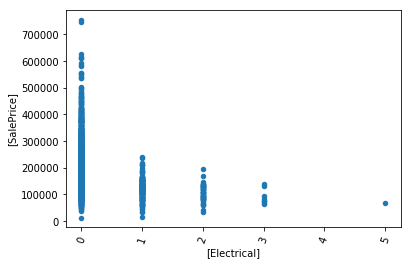

-0.23184418619391822
remove scattered record due to low correlation


In [77]:
main.plot(kind = 'scatter', x = ['Electrical'], y = ['SalePrice'], rot=70)
plt.show()

print(main['Electrical'].corr(main['SalePrice']))
main = main[main.Electrical < 5]
print('remove scattered record due to low correlation')

### 7.7	Remove outliers, low frequency records (only 1 occurance in a feature)
- We firstly identify features that we want to check. For each of those features, we identify unique values and its occurances. We then remove records with only 1 occurance


In [78]:
#Remove records with 1 occurrance
low_freq = ['Condition2','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterCond','Heating','Electrical',
            'BsmtFullBath','BedroomAbvGr','KitchenAbvGr','KitchenQual', 'TotRmsAbvGrd', 'GarageCars']

for i in low_freq:
    count = main[i].value_counts()
    main.drop(main[main[i].isin(count[count == 1].index)].index ,inplace=True)


#### 7.8 Remove Utilities column
- There 2 records scattered,  we assume that this is a noise. After removing these 2 records we realized that we are left with only 1 constant values, this means that we can delete this column as no combination with other features will make any difference.


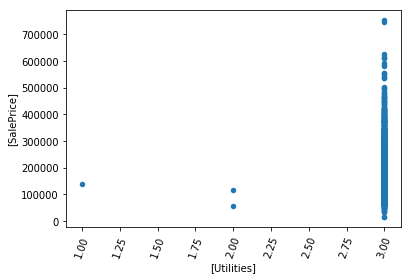

Correlation between Utilities and SalePrice: 0.026126539779602716
Seeing low correlation and low variety on values, we can drop this column


In [79]:
main.plot(kind = 'scatter', x = ['Utilities'], y = ['SalePrice'], rot=70)
plt.show()

print('Correlation between Utilities and SalePrice:',main['Utilities'].corr(main['SalePrice']))
print('Seeing low correlation and low variety on values, we can drop this column')
main = main.drop('Utilities', 1)

##### Checking Correlations but decided to let them be

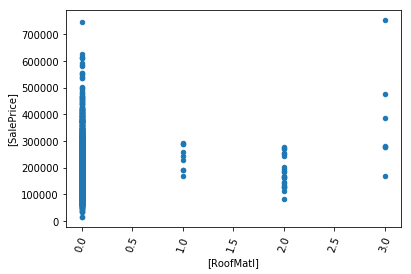

In [80]:
main.plot(kind = 'scatter', x = ['RoofMatl'], y = ['SalePrice'], rot=70)
plt.show()

0.12742540277040298

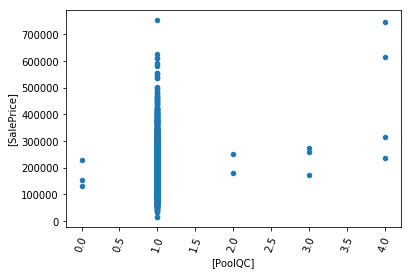

In [81]:
main.plot(kind='scatter',x=['PoolQC'], y=['SalePrice'], rot=70)
main['PoolQC'].astype('float').corr(main['SalePrice'])

In [82]:
main.shape

(2907, 79)

### 8. Feature engineering
To add new features which are potentially useful for the next process

#### New column 'Period' 
- Trying to see if the Year and month combined together (called it 'Period') will have a good correlation with the SalePrice
- After checking that the correlation between Period and Sale Price is lower than the correlation between Month and SalePrice, we decided to drop this

In [83]:
#Trying to see if the Year and month combined together will have a good correlation with the SalePrice
#Create a 'Period' column by adding year and month/12
main['Period'] = main['YrSold'] + main['MoSold']/12

print('Correlation between Period and SalePrice : ', main['SalePrice'].corr(main['Period']))
print('Correlation between Month and SalePrice : ', main['SalePrice'].corr(main['MoSold']))

main = main.drop('Period', 1)
print('Drop column Period as it does not have better correlation with SalePrice')


Correlation between Period and SalePrice :  -0.024275674713065288
Correlation between Month and SalePrice :  0.03600070215712215
Drop column Period as it does not have better correlation with SalePrice


#### 8.1 Create new feature, TotalSize
- A new feature 'TotalSize' is created by adding 'TotalBsmtSF'  and 'GrLivArea'


In [84]:
#get total size of the houses which probably correlates better
main['TotalSize'] = main['TotalBsmtSF']+ main['GrLivArea']

print('As we can see from below correlation, the main total square feet of the house have greater correlation')
main.loc[:,['TotalSize','TotalBsmtSF','GrLivArea','SalePrice']].corr()

As we can see from below correlation, the main total square feet of the house have greater correlation


,TotalSize,TotalBsmtSF,GrLivArea,SalePrice
TotalSize,1.000000,0.810318,0.863978,0.830862
TotalBsmtSF,0.810318,1.000000,0.405033,0.659310
GrLivArea,0.863978,0.405033,1.000000,0.729835
SalePrice,0.830862,0.659310,0.729835,1.000000


#### 8.2 Create new feature, HouseAge
- A new feature 'HouseAge' is created by substracting 'YrSold'  and 'YearBuilt'. The new feature has quite high correlation, therefore we decided to keep it.


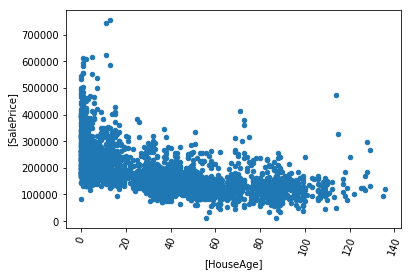

Correlation with new feature:  -0.5611183325883216


In [85]:
main['HouseAge'] = main['YrSold']-main['YearBuilt'] 
main.plot(kind = 'scatter', x = ['HouseAge'], y = ['SalePrice'], rot=70)
plt.show()
print('Correlation with new feature: ', main['HouseAge'].corr(main['SalePrice']))


#### 8.3 Create new feature, Remodeled
- A new feature 'Remodeled' with values 0 or 1, is created. It is to indicate whether the house has been remodeled. If the year of Remodel/Add is the same as the built year then set to 0, else set to 1.

In [86]:
##Create new Feature remodelled (0 or 1), if the year of Remodel/Add is the same as the built year then set to 0, else set to 1
main['Remodeled'] = (main['YearRemod/Add'] != main['YearBuilt']).astype(np.int64)
print('Correlation with new feature: ', main['Remodeled'].corr(main['SalePrice']))

Correlation with new feature:  -0.047775009687751745


### 8.4	Create new feature, TotalBathroom
- A new feature 'TotalBathroom' is created to identify number of bathrooms in a house. Equation used: TotalBathroom = BsmtFullBath + BsmtHalfBath/2 + FullBath +HalfBath/2. Correlation with SalePrice  is quite high, so we keep it.


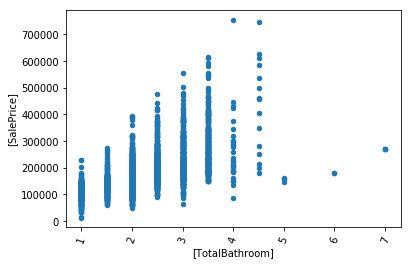

Correlation with new feature: 0.6369426678489398


In [87]:
##Create new Feature called Total Bathroom Bsmt Full Bath	Bsmt Half Bath	Full Bath	Half Bath
main['TotalBathroom'] = main['BsmtFullBath']+main['BsmtHalfBath']/2+main['FullBath']+main['HalfBath']/2 
main.plot(kind = 'scatter', x = ['TotalBathroom'], y = ['SalePrice'], rot=70)
plt.show()

print('Correlation with new feature:', main['TotalBathroom'].corr(main['SalePrice']))

#### 8.5 Create new feature, TtlGarageQ
- A new feature 'TtlGarageQ' is created by adding 'GarageFinish', 'GarageQual', 'GarageCond'. The new feature has high correlation, therefore we decided to keep it.
- Correlation with SalePrice it is quite high, so we keep it.


In [88]:
#added new feature TtlGarageQ

main['TtlGarageQ'] = main['GarageFinish'] + main['GarageQual'] + main['GarageCond']
print('Correlation of new feature: ', main['SalePrice'].corr(main['TtlGarageQ']))
main[['GarageFinish','GarageQual','GarageCond','SalePrice']].corr()

Correlation of new feature:  0.4650618222509379


,GarageFinish,GarageQual,GarageCond,SalePrice
GarageFinish,1.000000,0.459181,0.463637,0.551750
GarageQual,0.459181,1.000000,0.832333,0.288614
GarageCond,0.463637,0.832333,1.000000,0.279947
SalePrice,0.551750,0.288614,0.279947,1.000000


In [89]:
main[['GarageFinish','GarageQual','GarageCond','SalePrice']].corr()

,GarageFinish,GarageQual,GarageCond,SalePrice
GarageFinish,1.000000,0.459181,0.463637,0.551750
GarageQual,0.459181,1.000000,0.832333,0.288614
GarageCond,0.463637,0.832333,1.000000,0.279947
SalePrice,0.551750,0.288614,0.279947,1.000000


#### Move SalePrice column to the very last column in the dataframe
 - This way it is easier for the next step

In [90]:
#Move the SalePrice to the last Column
temp_SalePrice=main['SalePrice']
main.drop('SalePrice',axis=1,inplace=True)
main['SalePrice'] = temp_SalePrice




#### 8.6 Correlation matrix
- Based on correlation matrix below (in absolute value format), we found out that 'Condition2' and 'Foundation' has very low correlation with SalePrice. We then decided to remove these 2 features.

In [91]:
#Check Correlation between all columns and Sale Price
print('Correlation between all Columns and Sale Price =\n',abs(main.corrwith(main['SalePrice'],axis=0)).sort_values(axis=0, ascending=True))

#Drop Columns which have correlation < 0.01
main.drop('Foundation',axis=1,inplace=True)
main.drop('Condition2',axis=1,inplace=True)

main.shape


Correlation between all Columns and Sale Price =
 BsmtFinSF2       0.000362
SaleType         0.009404
Foundation       0.012479
LandContour      0.013703
ExterCond        0.018600
MiscVal          0.021955
Condition2       0.022346
YrSold           0.030159
MasVnrType       0.031748
3SsnPorch        0.032611
MoSold           0.036001
BsmtHalfBath     0.037725
LowQualFinSF     0.039502
Remodeled        0.047775
LotConfig        0.051949
LandSlope        0.055069
Condition1       0.057790
MiscFeature      0.064452
Street           0.065770
PoolArea         0.072219
Neighborhood     0.084683
RoofMatl         0.085542
MSSubClass       0.085930
Heating          0.089597
HouseStyle       0.099104
OverallCond      0.107861
ScreenPorch      0.111708
Functional       0.120166
KitchenAbvGr     0.121605
PoolQC           0.127425
                   ...   
LotArea          0.349433
LotFrontage      0.354661
BsmtFinType1     0.392820
BsmtExposure     0.408432
BsmtFinSF1       0.446949
HeatingQC     

(2907, 82)

#### 8.7 Normalization
- Normalization is done by substracting with the mean and dividing by the standard deviation, for all features except SalePrice (the target feature). 
- This normalization is optional. In the Data.py, this can be deactivated and normalization can be done in the later stage after splitting the data for the ANN using the standard scaler from Scikit Learn.


In [92]:
##Normalization with substracting data with the mean and divided by the standard deviation
normalized_main=(main-main.mean())/main.std()    
normalized_main['SalePrice'] = main['SalePrice'] 
normalized_main.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,MoSold,YrSold,SaleType,SaleCondition,TotalSize,HouseAge,Remodeled,TotalBathroom,TtlGarageQ,SalePrice
0,-0.878022,-0.521634,3.562460,4.270195,-0.06162,0.257186,-1.378351,-0.301601,-1.533133,-0.213206,...,-0.448085,1.674033,-0.281877,0.392182,0.254436,0.450349,-0.927782,-0.268140,0.877971,215000
1,-0.878022,0.318006,0.554741,0.340888,-0.06162,0.257186,0.747307,-0.301601,0.063148,-0.213206,...,-0.079186,1.674033,-0.281877,0.392182,-0.997925,0.417333,-0.927782,-1.511332,-0.194408,105000
2,-0.878022,-0.521634,0.604047,0.856721,-0.06162,0.257186,-1.378351,-0.301601,-1.533133,-0.213206,...,-0.079186,1.674033,-0.281877,0.392182,0.152469,0.516380,-0.927782,-0.889736,-0.194408,172000
3,-0.878022,-0.521634,1.195730,0.250788,-0.06162,0.257186,0.747307,-0.301601,-1.533133,-0.213206,...,-0.816984,1.674033,-0.281877,0.392182,2.194418,0.186225,-0.927782,1.596649,0.877971,244000
4,0.061271,-0.521634,0.258899,0.771497,-0.06162,0.257186,-1.378351,-0.301601,0.063148,-0.213206,...,-1.185883,1.674033,-0.281877,0.392182,0.020435,-0.771225,1.077469,0.353457,0.877971,189900
5,0.061271,-0.521634,0.456127,0.020271,-0.06162,0.257186,-1.378351,-0.301601,0.063148,-0.213206,...,-0.079186,1.674033,-0.281877,0.392182,-0.014861,-0.804240,-0.927782,0.353457,0.877971,195500
6,1.470210,-0.521634,-1.368228,-0.966151,-0.06162,0.257186,0.747307,-0.301601,0.063148,-0.213206,...,-0.816984,1.674033,-0.281877,0.392182,0.176000,-0.903287,-0.927782,0.975053,0.877971,213500
7,1.470210,-0.521634,-1.269614,-0.949574,-0.06162,0.257186,-1.378351,1.431114,0.063148,-0.213206,...,-1.923681,1.674033,-0.281877,0.392182,0.024357,-0.606147,-0.927782,-0.268140,0.341782,191500
8,1.470210,-0.521634,-1.466841,-0.874685,-0.06162,0.257186,-1.378351,-0.301601,0.063148,-0.213206,...,-1.185883,1.674033,-0.281877,0.392182,0.875387,-0.705194,1.077469,0.975053,0.341782,236500
9,0.061271,-0.521634,-0.431397,-0.462994,-0.06162,0.257186,0.747307,-0.301601,0.063148,-0.213206,...,-0.079186,1.674033,-0.281877,0.392182,0.335486,-0.837256,-0.927782,0.353457,0.877971,189000


In [93]:
#To reset the index after removing lines
normalized_main.reset_index(drop=True)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,MoSold,YrSold,SaleType,SaleCondition,TotalSize,HouseAge,Remodeled,TotalBathroom,TtlGarageQ,SalePrice
0,-0.878022,-0.521634,3.562460,4.270195,-0.06162,0.257186,-1.378351,-0.301601,-1.533133,-0.213206,...,-0.448085,1.674033,-0.281877,0.392182,0.254436,0.450349,-0.927782,-0.268140,0.877971,215000
1,-0.878022,0.318006,0.554741,0.340888,-0.06162,0.257186,0.747307,-0.301601,0.063148,-0.213206,...,-0.079186,1.674033,-0.281877,0.392182,-0.997925,0.417333,-0.927782,-1.511332,-0.194408,105000
2,-0.878022,-0.521634,0.604047,0.856721,-0.06162,0.257186,-1.378351,-0.301601,-1.533133,-0.213206,...,-0.079186,1.674033,-0.281877,0.392182,0.152469,0.516380,-0.927782,-0.889736,-0.194408,172000
3,-0.878022,-0.521634,1.195730,0.250788,-0.06162,0.257186,0.747307,-0.301601,-1.533133,-0.213206,...,-0.816984,1.674033,-0.281877,0.392182,2.194418,0.186225,-0.927782,1.596649,0.877971,244000
4,0.061271,-0.521634,0.258899,0.771497,-0.06162,0.257186,-1.378351,-0.301601,0.063148,-0.213206,...,-1.185883,1.674033,-0.281877,0.392182,0.020435,-0.771225,1.077469,0.353457,0.877971,189900
5,0.061271,-0.521634,0.456127,0.020271,-0.06162,0.257186,-1.378351,-0.301601,0.063148,-0.213206,...,-0.079186,1.674033,-0.281877,0.392182,-0.014861,-0.804240,-0.927782,0.353457,0.877971,195500
6,1.470210,-0.521634,-1.368228,-0.966151,-0.06162,0.257186,0.747307,-0.301601,0.063148,-0.213206,...,-0.816984,1.674033,-0.281877,0.392182,0.176000,-0.903287,-0.927782,0.975053,0.877971,213500
7,1.470210,-0.521634,-1.269614,-0.949574,-0.06162,0.257186,-1.378351,1.431114,0.063148,-0.213206,...,-1.923681,1.674033,-0.281877,0.392182,0.024357,-0.606147,-0.927782,-0.268140,0.341782,191500
8,1.470210,-0.521634,-1.466841,-0.874685,-0.06162,0.257186,-1.378351,-0.301601,0.063148,-0.213206,...,-1.185883,1.674033,-0.281877,0.392182,0.875387,-0.705194,1.077469,0.975053,0.341782,236500
9,0.061271,-0.521634,-0.431397,-0.462994,-0.06162,0.257186,0.747307,-0.301601,0.063148,-0.213206,...,-0.079186,1.674033,-0.281877,0.392182,0.335486,-0.837256,-0.927782,0.353457,0.877971,189000
